# Machine Learning - Project 2:
# _Autoencoder for mathematical modeling of blood flow in a stenosis context_

## Context

In this project, we are going to analyze data derived from...

Our goals:
1. modeliser mathématiquement l’écoulement sanguin à l’aide de PDE dépendante de 2-3 paramètres physique
2. simuler l’écoulement par un code d’éléments fini ou similaire
3. générer beaucoup de solutions avec une grande nombre de paramètres différents. (Les 2-3, pris de façon aléatoire)
4. a. utiliser les solutions numérique pour établir un auto encoder qui au milieu n’ai que 2-5 hyper-paramètres libres  
b. quel erreur on obtient ? Est-ce possible de réduire le nombre d’hyper-paramètres ?
5. étudier s’il y a une rélation entre les 2-5 hyper-paramètre et les paramètres physique  
a. à l’aide de statistiques
5. b. à l’aide d’un DNN (différent de 4a)
6. (optionnel) faire un DNN entre l’input de 4a et output les paramêtres physique. Et/ou l’inverse.
7. Discussion et conclusions 

Abbreviations used:
- $N_u$ = total number of spatial points per simulation
- $N_t$ = total number of time steps per simulation
- $N_s$ = total number of simulations

## Table of contents

[1. Data exploration](#data_exploration) 
- [Imports](#1imports)
- [Pathways](#1pathways)
- [Loading](#1load)
- [Exploration](#1exploration)

[2. Data preprocessing](#preprocessing)

[3. Pickle](#pickle)

[4. Autoencoder](#autoencoder)

### Imports  <a name="1imports"></a>

In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from helpers import *
from preprocessing import *
from sklearn.model_selection import train_test_split
from autoencoder import *
from crossvalidation import *
import _pickle as cPickle
%load_ext autoreload
%autoreload 2
torch.manual_seed(0)
np.random.seed(1)
seed = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Data exploration  <a name="data_exploration"></a>

### Pathways <a name="1pathways"></a>

In [2]:
DATA_PATH = 'data/'
DATA_Ux_PATH = DATA_PATH + 'u1_small.csv.bz2'
DATA_Uy_PATH = DATA_PATH + 'u2_small.csv.bz2'

### Loading <a name="1load"></a>

Let's load the data which consists of 2 matrices Ux, Uy denoting the x and y coordinates of the speed.

In [7]:
# Loading
Ux_pd = pd.read_csv(DATA_Ux_PATH, header=None)
Uy_pd = pd.read_csv(DATA_Uy_PATH, header=None)
# Converting from dataframe to numpy
Ux = Ux_pd.to_numpy()
Uy = Uy_pd.to_numpy()

### Exploration <a name="1exploration"></a>

Let's have a closer look at our imported data sets. The columns represent the time steps and the rows represent a point of our blood vessel mesh and each 5509 row a new simulation.

In [8]:
print("Our input array Ux is of shape:",Ux.shape)
print("Our input array Uy is of shape:",Uy.shape)
print("Printing a row of Ux:", '\n', Ux[10,:], '\n')
print("Printing a row of Uy:", '\n', Uy[10,:], '\n')

Our input array Ux is of shape: (2754500, 110)
Our input array Uy is of shape: (2754500, 110)
Printing a row of Ux: 
 [0.11815144 0.46919116 1.02975707 1.74912707 2.55882652 3.38057346
 4.13444846 4.74694366 5.15826672 5.32824932 5.50112988 5.66311518
 5.81717249 5.9647965  6.10671862 6.24331737 6.3747969  6.50127033
 6.6228015  6.73942699 6.85116806 6.9580373  7.06004233 7.15718784
 7.24947683 7.33691128 7.41949249 7.49722139 7.57009862 7.63812466
 7.70129983 7.75962439 7.81309854 7.86172241 7.9054961  7.94441969
 7.97849325 8.00771682 8.03209043 8.05161411 8.06628787 8.07611173
 8.0810857  8.08193401 8.0810603  8.07882546 8.07530674 8.07053833
 8.06453707 8.05731176 8.04886719 8.03920607 8.02832997 8.0162398
 8.00293612 7.98841929 7.9726895  7.95574692 7.93759164 7.91822371
 7.89764319 7.87585012 7.85284451 7.82862639 7.80319576 7.77655263
 7.74869702 7.71962893 7.68934837 7.65785533 7.62514982 7.59123184
 7.55610139 7.51975847 7.48220309 7.44343524 7.40345492 7.36226214
 7.3198569  

For the rest of the analysis, we need to figure out the number of simulation step. As we know that we previsouly generated 25 simulations on Matlab and all the new simulations are appended row-wise, we can deduce it with the following computation.

In [9]:
positions =5509 #We know it from the matlab code
times = Ux.shape[1]
simulations = int(Ux.shape[0]/positions)
print("We ran ", simulations, "simulations with different parameters for each simulation (parameters of the stenosis and resistance of the blood flow in the bifurcations)")
print("1 simulation calculate the velocities of the blood flow at ", positions, " different positions and at ", times, " different times")

We ran  500 simulations with different parameters for each simulation (parameters of the stenosis and resistance of the blood flow in the bifurcations)
1 simulation calculate the velocities of the blood flow at  5509  different positions and at  110  different times


## 2. Data preprocessing  <a name="preprocessing"></a>

Let's check if we have any NaN or None values in our dataframe.

In [10]:
print(np.count_nonzero(np.isnan(Ux)))
print(np.count_nonzero(np.isnan(Uy)))

0
0


It seems there are no None values so we can start direclty preprocess our datasets.

ADDITIONAL IDEAS FOR PREPROCESSING
- remove columns with 0 std dev?
- standardization?

Let's sample our data points into the following ratios : 

In [11]:
ratio_pts = 0.1
ratio_time = 1

new_Ux, new_Uy, new_inds = sample(Ux, Uy, ratio_pts, ratio_time)
print(new_Ux.shape, new_Uy.shape)

(275000, 110) (275000, 110)


In [12]:
new_Nu, new_Nt = get_Nu_Nt_sampled(Ux, new_Ux)

print('With the sampling we got from ', 5509, ' positions to ', new_Nu, ' positions')
print('With the sampling we got from ', 110, ' time steps to ', new_Nt, ' time steps')

With the sampling we got from  5509  positions to  550  positions
With the sampling we got from  110  time steps to  110  time steps


We can look at the positions of the sampled positions to make sure that we cover mostly all the important parts of the geometry of the artery :

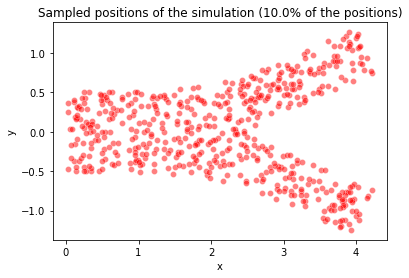

In [13]:
plot_sampled_coord(new_inds) 

In [14]:
print(new_Ux)

[[0.10320396 0.40350367 0.87012142 ... 4.10688429 4.04805516 3.98832605]
 [0.01594456 0.05410392 0.10113175 ... 0.24141005 0.23775211 0.23403981]
 [0.09708471 0.3791298  0.81640834 ... 3.77562197 3.7214011  3.66635184]
 ...
 [0.0703612  0.2799323  0.61499102 ... 3.27853814 3.23202877 3.18480423]
 [0.02925616 0.10388787 0.20333289 ... 0.55864231 0.55023205 0.5416964 ]
 [0.0366683  0.13315813 0.26695491 ... 0.87738624 0.86444316 0.85130507]]


Let's flatten our matrices into a single matrix with dimensions $((2 N_u N_t), N_s)$. For each simulation, the x and y speed coordinates are compressed to the following 1D matrix:

$$
\mathbf{M_{1D}}
=
\begin{bmatrix}
\vdots \\
u_{x}^{(0)} \\
\vdots \\
u_{y}^{(0)} \\
\vdots \\
u_{x}^{(1)} \\
\vdots \\
u_{y}^{(1)} \\
\vdots \\
u_{x}^{(N_t - 1)} \\
\vdots \\
u_{y}^{(N_t - 1)} \\
\vdots 
\end{bmatrix}
$$



In [15]:
flattened_array = flatten(new_Ux, new_Uy, ratio_pts)
flattened_array.shape

(500, 121000)

Let's make a sanity check that the dimension of 1 datapoint is indeed ${2 * new_{N_t} * new_{N_u})}$

In [16]:
assert flattened_array.shape[1] == 2*new_Nt*new_Nu

print(2*new_Nt*new_Nu)

121000


## 3. Pickle  <a name="pickle"></a>

To avoid the loading and processing steps each time we open the notebook, we will save the processed matrix "flattened_array" using pickle : 

In the following cell, we will create pickles for every subsampled data according to the ratios_pts and the ratios_t :

In [17]:
ratios_pts = [0.1, 0.05, 0.01]
ratios_t = [1, 0.7, 0.5]

create_subsamples(Ux, Uy, ratios_pts, ratios_t, name_file='small')

#### Start from here if you the pickle file already exist in your data folder

Change only the following cell to change the name of the file you want to open :

In [9]:
ratios = [0.1, 1]
size = ['very_small', 'small', 'large']

name = 'processed_'+str(size[0])+'_'+str(ratios[0])+'_'+str(ratios[1])

print('name of the file you want to read : ', name)

name of the file you want to read :  processed_very_small_0.1_1


In [10]:
flattened_array  = cPickle.load(open("data/pickle/"+name, "rb"))

In [11]:
print(flattened_array)

[[ 5.83595480e-02  1.52145667e-02  5.22789790e-02 ...  1.15737658e+00
   1.55849375e-02  2.92919825e-03]
 [ 6.44804449e-02  1.52124591e-02  6.16749165e-02 ...  1.00064311e+00
   1.90184736e-02  1.49603115e-03]
 [ 1.48231783e-01  2.60291062e-02  1.49105089e-01 ...  1.35700848e+00
  -1.24456466e-02 -3.07817755e-02]
 ...
 [ 9.96757422e-02  1.29199047e-02  8.22345984e-02 ...  2.81204562e+00
   4.43430272e-02 -2.37746577e-03]
 [ 1.85973493e-01  4.85260306e-02  1.79182342e-01 ...  2.75500884e+00
   3.01528775e-02 -1.73596756e-02]
 [ 1.65302611e-01  3.80143624e-02  1.64879092e-01 ...  1.57594949e+00
   2.31178495e-02  1.86886345e-02]]


##### Final step : split train/test

We split the data set into a training a testing set to be able to evaluate our autoencoder.

In [12]:
x_train, x_test = train_test_split(flattened_array, test_size=0.1, random_state=seed)
y_train, y_test = x_train, x_test

print(x_train.shape)
print(x_test.shape)

(22, 121000)
(3, 121000)


## 4. Auto-encoder  <a name="autoencoder"></a>

In [13]:
# define network parameters
learningRate=1e-2
epochs=50
input_size=x_train.shape[1]
k_folds = 5

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss() 

--------------------------------
FOLD 0
--------------------------------
Epoch:1/50 Training Error:0.979 Test Error:0.972
Epoch:2/50 Training Error:0.737 Test Error:0.720
Epoch:3/50 Training Error:0.744 Test Error:0.726
Epoch:4/50 Training Error:0.958 Test Error:0.952
Epoch:5/50 Training Error:0.944 Test Error:0.946
Epoch:6/50 Training Error:0.850 Test Error:0.844
Epoch:7/50 Training Error:0.535 Test Error:0.524
Epoch:8/50 Training Error:0.469 Test Error:0.480
Epoch:9/50 Training Error:0.869 Test Error:0.855
Epoch:10/50 Training Error:0.837 Test Error:0.777
Epoch:11/50 Training Error:0.597 Test Error:0.587
Epoch:12/50 Training Error:1.372 Test Error:0.913
Epoch:13/50 Training Error:0.356 Test Error:0.405
Epoch:14/50 Training Error:0.314 Test Error:0.268
Epoch:15/50 Training Error:0.522 Test Error:0.650
Epoch:16/50 Training Error:0.161 Test Error:0.334
Epoch:17/50 Training Error:0.467 Test Error:0.513
Epoch:18/50 Training Error:0.600 Test Error:0.266
Epoch:19/50 Training Error:0.431 Tes

Epoch:10/50 Training Error:0.846 Test Error:0.601
Epoch:11/50 Training Error:0.512 Test Error:0.262
Epoch:12/50 Training Error:0.428 Test Error:0.441
Epoch:13/50 Training Error:0.403 Test Error:0.265
Epoch:14/50 Training Error:0.672 Test Error:0.714
Epoch:15/50 Training Error:0.635 Test Error:0.627
Epoch:16/50 Training Error:0.476 Test Error:0.122
Epoch:17/50 Training Error:0.426 Test Error:0.560
Epoch:18/50 Training Error:0.520 Test Error:0.509
Epoch:19/50 Training Error:0.520 Test Error:0.426
Epoch:20/50 Training Error:0.502 Test Error:0.267
Epoch:21/50 Training Error:0.760 Test Error:0.806
Epoch:22/50 Training Error:0.438 Test Error:0.365
Epoch:23/50 Training Error:0.365 Test Error:0.337
Epoch:24/50 Training Error:0.476 Test Error:0.330
Epoch:25/50 Training Error:0.594 Test Error:0.413
Epoch:26/50 Training Error:0.497 Test Error:0.103
Epoch:27/50 Training Error:0.376 Test Error:0.270
Epoch:28/50 Training Error:0.339 Test Error:0.141
Epoch:29/50 Training Error:0.521 Test Error:0.393


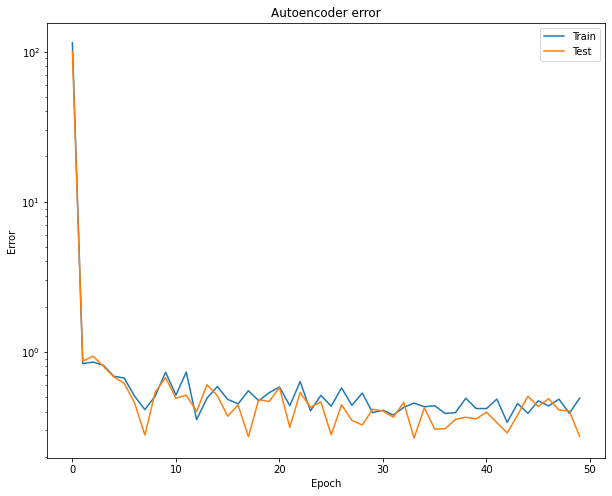

0.27309667995673725

In [14]:
#Sur c'est flattened_array et pas flattened_array_train qu'il faut donner ?????
#Seed problem pas fixée
Kfold(x_train, k_folds, input_size, epochs, criterion, learningRate)

#### Parameters tuning

Find the best learning rate of our model using cross-validation :

In [15]:
# define network parameters
learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]
epochs=50
input_size=x_train.shape[1]
k_folds = 5

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss()  

Learning rate =  0.1

Performance of 5 fold cross validation: 
Average Training Error: 0.968 	 Average Test Error: 0.968
 
Learning rate =  0.05

Performance of 5 fold cross validation: 
Average Training Error: 0.959 	 Average Test Error: 0.961
 
Learning rate =  0.01

Performance of 5 fold cross validation: 
Average Training Error: 0.491 	 Average Test Error: 0.273
 
Learning rate =  0.005

Performance of 5 fold cross validation: 
Average Training Error: 0.482 	 Average Test Error: 0.268
 
Learning rate =  0.001

Performance of 5 fold cross validation: 
Average Training Error: 0.481 	 Average Test Error: 0.310
 

Best learning rate is  0.005  with a best error of :  0.26839007330709225



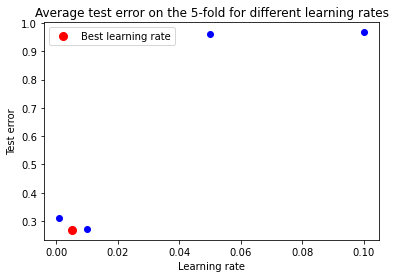

In [16]:
best_result, best_lr = tuning_lr(x_train, k_folds, input_size, epochs, criterion, learning_rates)

Find the best number of neurons in the latent space (neurons in the "middle layer of the auto-encoder") in the auto-encoder (which is actually the dimension of the compressed data) : 

In [17]:
# define network parameters
lr = best_lr # from above
epochs=50
input_size=x_train.shape[1]
k_folds = 5
number_neurons = [3, 5, 6, 8, 10]

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss()  

Number of neurons =  3

Performance of 5 fold cross validation: 
Average Training Error: 0.487 	 Average Test Error: 0.214
 
Number of neurons =  5

Performance of 5 fold cross validation: 
Average Training Error: 0.482 	 Average Test Error: 0.268
 
Number of neurons =  6

Performance of 5 fold cross validation: 
Average Training Error: 0.546 	 Average Test Error: 0.393
 
Number of neurons =  8

Performance of 5 fold cross validation: 
Average Training Error: 0.536 	 Average Test Error: 0.468
 
Number of neurons =  10

Performance of 5 fold cross validation: 
Average Training Error: 0.440 	 Average Test Error: 0.336
 
The results obtained for the number of latent neurons tested are the following : [0.21428009465638706, 0.26839007330709225, 0.3927613985996132, 0.4676936135527022, 0.33584743611670637].
The best average test error obtained is 0.21428009465638706, and it is obtained with 3 neurons in the latent layer.


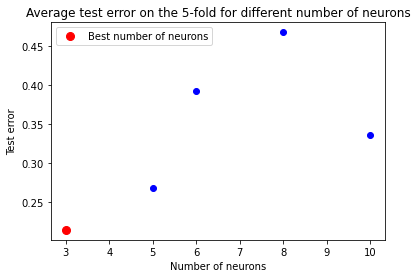

In [18]:
best_result, best_neurons_nb = tuning_latent_layer(x_train, k_folds, input_size, epochs, criterion, lr, number_neurons)

## 4. Passer en 2D 

Instead of flattenning our initial dataset into a colummn vector for each simulation, we split it into a 2D matrix for each simulation such as the following:

$$
\mathbf{M_{2D}}
=
\begin{bmatrix}
\vdots & \vdots & \vdots & \vdots \\
u_{x}^{(0)} & u_{x}^{(1)} & \cdots &
u_{x}^{(N_t - 1)} \\
\vdots & \vdots & \ddots & \vdots \\
u_{y}^{(0)} & u_{y}^{(1)} & \cdots &
u_{y}^{(N_t - 1)} \\
\vdots & \vdots & \vdots & \vdots
\end{bmatrix}
$$

In [16]:
flattened_array = flatten_2d(new_Ux, new_Uy, ratio_pts)
flattened_array.shape

(25, 1100, 110)

## 5. Passer en 4D

In [ ]:
flattened_array_4d = flatten_4d(new_Ux, new_Uy, ratio_pts)
flattened_array_4d.shape

In [ ]:
flattened_array_4d = normalize(flattened_array_4d)

In [ ]:
x_train, x_test = train_test_split(flattened_array_4d, test_size=0.1, random_state=seed)

In [ ]:
import h5py

In [ ]:
hf = h5py.File('trainset.h5', 'w')
hf.create_dataset('dataset_1', data=x_train)

In [ ]:
hf = h5py.File('testset.h5', 'w')
hf.create_dataset('dataset_1', data=x)

## 6. Discussion & conclusion